In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


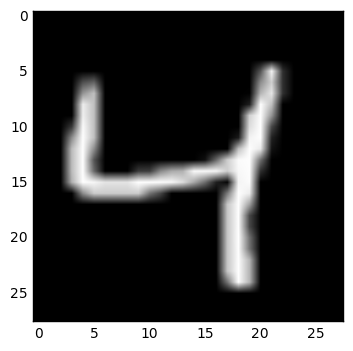

In [3]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')
plt.show()

In [4]:
# building model 
x = tf.placeholder(shape=[None, 28, 28, 1], dtype=tf.float32)
y_ = tf.placeholder(shape=[None, 28, 28, 1], dtype=tf.float32)

## building encoder
# 1st conv layer
# 28 x 28 x16
W_conv1 = tf.Variable(dtype=tf.float32, 
                 initial_value=tf.truncated_normal(shape=[3, 3, 1, 16], stddev=0.1))
b_conv1 = tf.Variable(dtype=tf.float32, 
                     initial_value=tf.constant(shape=[16], value=0.1))
conv2d_1 = tf.nn.conv2d(input=x, filter=W_conv1, strides=[1, 1, 1, 1], padding="SAME")
h_conv1 = tf.nn.relu(conv2d_1 + b_conv1)
# 14 x 14 x 16
h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")

# 2nd conv layer
# 14 x 14 x 8
W_conv2 = tf.Variable(dtype=tf.float32, 
                      initial_value=tf.truncated_normal(shape=[3, 3, 16, 8], stddev=0.1))
b_conv2 = tf.Variable(dtype=tf.float32, 
                     initial_value=tf.constant(shape=[8], value=0.1))
conv2d_2 = tf.nn.conv2d(h_pool1, W_conv2, strides=[1, 1, 1, 1], padding="SAME")
h_conv2 = tf.nn.relu(conv2d_2 + b_conv2)
# 7 x 7 x 8
h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")

# 3rd conv layer 
# 7 x 7 x8
W_conv3 = tf.Variable(dtype=tf.float32, 
                      initial_value=tf.truncated_normal(shape=[3, 3, 8, 8], stddev=0.1))
b_conv3 = tf.Variable(dtype=tf.float32, 
                      initial_value=tf.constant(shape=[8], value=0.1))
conv2d_3 = tf.nn.conv2d(h_pool2, W_conv3, strides=[1, 1, 1, 1], padding="SAME")
h_conv3 = tf.nn.relu(conv2d_3 + b_conv3)
# 4 x 4 x 8
encoded = tf.nn.max_pool(h_conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")



In [8]:
## buildig decoder 
# upsample 1
# 7 x 7 x 8
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7, 7))

# 4th conv layer
# 7 x 7 x 8 
W_conv4 = tf.Variable(dtype=tf.float32, 
                      initial_value=tf.truncated_normal(shape=[3, 3, 8, 8], stddev=0.1))
b_conv4 = tf.Variable(dtype=tf.float32, 
                       initial_value=tf.constant(shape=[8], value=0.1))
conv2d_4 = tf.nn.conv2d(input=upsample1, filter=W_conv4, strides=[1, 1, 1, 1], padding="SAME")
h_conv4 = tf.nn.relu(conv2d_4 + b_conv4)

# upsample 2
# 14 x 14 x 8 
upsample2 = tf.image.resize_nearest_neighbor(h_conv4, (14, 14))

# 5th conv layer 
# 14 x 14 x 8
W_conv5 = tf.Variable(dtype=tf.float32, 
                      initial_value=tf.truncated_normal(shape=[3, 3, 8, 8], stddev=0.1))
b_conv5 = tf.Variable(dtype=tf.float32, 
                      initial_value=tf.constant(shape=[8], value=0.1))
conv2d_5 = tf.nn.conv2d(input=upsample2, filter=W_conv5, strides=[1, 1, 1, 1], padding="SAME")
h_conv5 = tf.nn.relu(conv2d_5 + b_conv5)

# upsample 3
# 28 x 28 x 8
upsample3 = tf.image.resize_nearest_neighbor(h_conv5, (28, 28))

# 6th conv layer
# 28 x 28 x 16
W_conv6 = tf.Variable(dtype=tf.float32, 
                       initial_value=tf.truncated_normal(shape=[3, 3, 8, 16], stddev=0.1))
b_conv6 = tf.Variable(dtype=tf.float32, 
                       initial_value=tf.constant(shape=[16], value=0.1))
conv2d_6 = tf.nn.conv2d(input=upsample3, filter=W_conv6, strides=[1, 1, 1, 1], padding="SAME")
h_conv6 = tf.nn.relu(conv2d_6 + b_conv6)

# logit layer
# 28 x 28 x 1
W_conv7 = tf.Variable(dtype=tf.float32, 
                       initial_value=tf.truncated_normal(shape=[3, 3, 16, 1], stddev=0.1))
b_conv7 = tf.Variable(dtype=tf.float32, 
                       initial_value=tf.constant(shape=[1], value=0.1))
conv2d_7 = tf.nn.conv2d(input=h_conv6, filter=W_conv7, strides=[1, 1, 1, 1], padding="SAME")
logits = conv2d_7 + b_conv7

decoded = tf.nn.sigmoid(logits, name="decoded")

In [9]:
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_, logits=logits)
cross_entropy = tf.reduce_mean(loss)
train_step = tf.train.AdamOptimizer(0.001).minimize(cross_entropy)

In [18]:
## Training 
sess = tf.Session()

epochs = 20
batch_size = 200

sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for i in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(200)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cross_entropy, train_step], 
                                 feed_dict={x: imgs, y_: imgs})

        if i%10 == 0:
            print("epoch {0}/ loss: {1:.4f} ".format(e+1, batch_cost))

epoch 1/ loss: 0.7510 
epoch 1/ loss: 0.5593 
epoch 1/ loss: 0.4860 
epoch 1/ loss: 0.4423 
epoch 1/ loss: 0.4137 
epoch 1/ loss: 0.3981 
epoch 1/ loss: 0.3673 
epoch 1/ loss: 0.3107 
epoch 1/ loss: 0.2516 
epoch 1/ loss: 0.2273 
epoch 1/ loss: 0.2094 
epoch 1/ loss: 0.2092 
epoch 1/ loss: 0.2036 
epoch 1/ loss: 0.2013 
epoch 1/ loss: 0.1973 
epoch 1/ loss: 0.1883 
epoch 1/ loss: 0.1976 
epoch 1/ loss: 0.1852 
epoch 1/ loss: 0.1826 
epoch 1/ loss: 0.1768 
epoch 1/ loss: 0.1792 
epoch 1/ loss: 0.1810 
epoch 1/ loss: 0.1738 
epoch 1/ loss: 0.1782 
epoch 1/ loss: 0.1731 
epoch 1/ loss: 0.1706 
epoch 1/ loss: 0.1730 
epoch 1/ loss: 0.1670 
epoch 1/ loss: 0.1679 
epoch 1/ loss: 0.1633 
epoch 2/ loss: 0.1633 
epoch 2/ loss: 0.1631 
epoch 2/ loss: 0.1617 
epoch 2/ loss: 0.1622 
epoch 2/ loss: 0.1655 
epoch 2/ loss: 0.1596 
epoch 2/ loss: 0.1583 
epoch 2/ loss: 0.1573 
epoch 2/ loss: 0.1588 
epoch 2/ loss: 0.1576 
epoch 2/ loss: 0.1557 
epoch 2/ loss: 0.1523 
epoch 2/ loss: 0.1525 
epoch 2/ lo

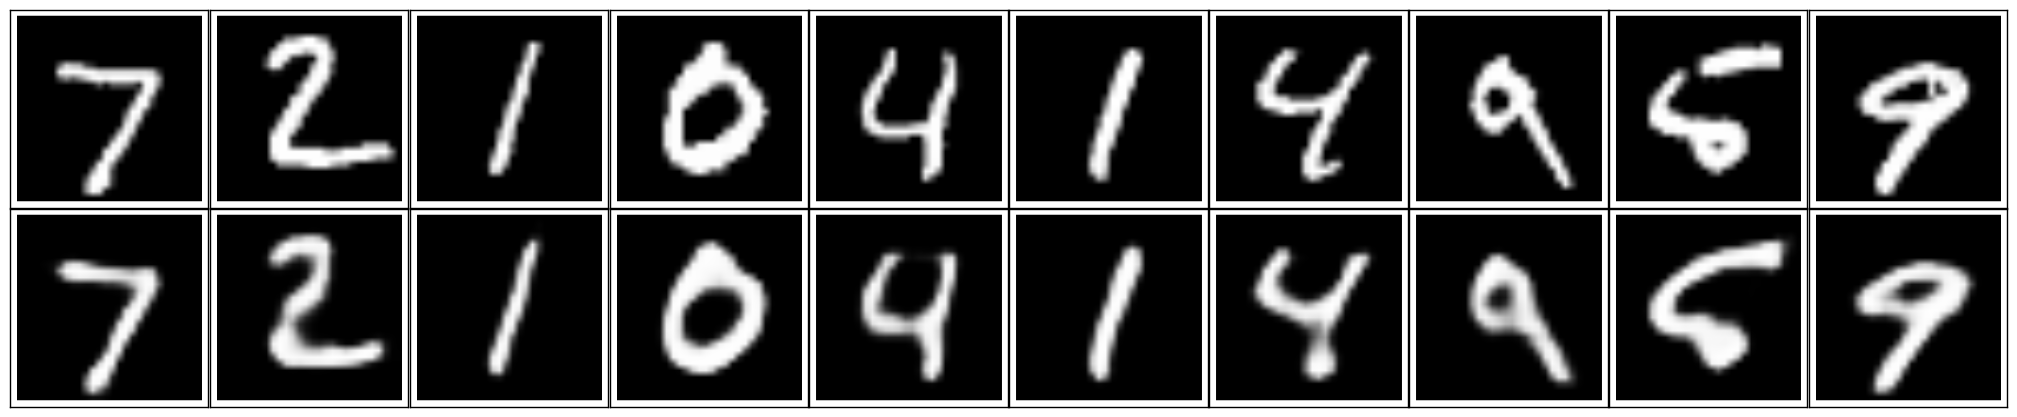

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={x: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)
plt.show()